## DSC180B Group11 Project Report

 #### This notebook serves to demonstrate different visual plots for exploratory data analysis(EDA) and dataset validation

In [1]:
# Necessary imports

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint

sys.path.insert(0, 'src')
from load_data import path_generator, load_jet_features, load_num_sv
from mass_distribution import mass_distribution
from sv_mass_distribution import sv_mass_distribution

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

----

### Generate sample jet data 

For performing EDA, we will utilize just certain number of QCD and Signal jets for memory and runtime optimization. Source of these files are located either in `train_mass_qcd` for QCD jets or `train_mass_hbb` for Signal jets. Those directories are then separated into numbers of subdirectories. On average, the size of `.root` files for QCD data is far smaller than those for Signal data; this is possibly due to QCD data existing in smaller partitioned files than Signal data. According to our calculation, approximately $55$ `.root` files of QCD jets are as big as $8$ `.root` files of Signal jets in terms of file(byte) size. Hence by default, `path_generator()` generates $55$ random QCD `.root` files and $8$ random Signal `.root` files.

In [3]:
qcd_eda_sets = path_generator('qcd', eda=True)
signal_eda_sets = path_generator('signal', eda=True)

print(f'Loaded {len(qcd_eda_sets)} QCD files and \
{len(signal_eda_sets)} Signal files')

Loaded 55 QCD files and 8 Signal files


----

### EDA\#1 Jet mass distribution

Our regression model is capable of predicting the mass, or weight, of particle jets based on the information learned from features relevant to jet and other existing components in the jet. These jets can be largely categorized into two distinct groups: `QCD` and `Signal`. Some signal jets are known to be relatively heavier than QCD jets due to the type of resulting decay products and their expected lifespan, which allow longer-living particles to be heavier.

##### Part1 -- Validation

Before exploring, we need to ensure each jet belongs to one and only one jet type. 

In [4]:
df_qcd = load_jet_features(qcd_eda_sets)
display(df_qcd.head())
print('\n', f'{df_qcd.shape[0]} randomly generated QCD jet samples')

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genW_decay,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi
0,498.25,1.052002,-0.563110,386.250,379.500000,-1000.0,-1000.0,0.068716,0.003523,421.750000,...,-99.0,-99.0,2616.0,-870.0000,1472.0,-2.681989,23.291080,0.228394,16.610394,-2.109741
1,472.25,-0.694092,2.504395,149.250,7.472656,-1000.0,-1000.0,0.000043,0.000970,8.929688,...,-99.0,-99.0,2616.0,-870.0000,1472.0,0.533691,23.291080,0.228394,16.610394,1.105939
2,567.50,-0.514160,-1.928467,118.125,67.500000,-1000.0,-1000.0,0.001148,0.002134,62.250000,...,-99.0,-99.0,1092.0,702.0000,2528.0,-1.741926,44.549541,2.433594,31.638157,-2.514386
3,515.50,-2.184570,1.184326,157.625,69.000000,-1000.0,-1000.0,0.433585,0.006259,115.125000,...,-99.0,-99.0,1092.0,702.0000,2528.0,1.428467,44.549541,2.433594,31.638157,0.656006
4,625.50,0.472900,-2.631836,153.875,142.375000,-1000.0,-1000.0,0.886114,0.002579,136.625000,...,-99.0,-99.0,650.0,-8.9375,750.0,-0.437012,17.063761,0.448975,23.588200,3.069275



 408712 randomly generated QCD jet samples


In [5]:
df_signal = load_jet_features(signal_eda_sets)
display(df_signal.head())
print('\n', f'{df_signal.shape[0]} randomly generated Signal jet samples')

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genW_decay,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi
0,1324.0,-0.178070,2.704590,370.750,162.25,-1000.0,-1000.0,8.770051e-04,0.674667,170.500,...,-99.0,-99.0,1588.0,344.00,1288.0,-2.999268,249.259521,48.468750,275.720337,-3.044373
1,1302.0,0.977905,-0.199585,242.000,149.75,-1000.0,-1000.0,1.818973e-01,0.999587,142.625,...,-99.0,-99.0,1588.0,344.00,1288.0,-0.095093,249.259521,48.468750,275.720337,-0.140198
2,1530.0,1.306641,-0.886719,311.000,215.25,-1000.0,-1000.0,9.985753e-06,0.014361,210.750,...,-99.0,-99.0,1636.0,80.25,1496.0,2.910156,164.068527,18.437500,136.723816,-2.892560
3,1318.0,-0.019722,2.220215,228.625,166.50,-1000.0,-1000.0,7.647397e-07,0.289642,170.000,...,-99.0,-99.0,1636.0,80.25,1496.0,-0.196777,164.068527,18.437500,136.723816,0.283691
4,1836.0,1.005859,-2.210938,1089.000,1113.00,-1000.0,-1000.0,7.672969e-04,0.999875,1046.000,...,-99.0,-99.0,5808.0,5568.00,8640.0,2.762207,124.052780,2.324219,157.942627,-3.113141



 580335 randomly generated Signal jet samples


In [6]:
# QCD
# For this checkup, we only need label attribute

IS_QCDb = 'fj_isQCDb'
IS_QCDothers = 'fj_isQCDothers'
all_attrs = df_qcd.columns.tolist()
start_idx = all_attrs.index(IS_QCDb)
end_idx = all_attrs.index(IS_QCDothers)+1

qcd_labels = all_attrs[start_idx:end_idx]

In [7]:
df_qcd_labels = df_qcd[qcd_labels]
display(df_qcd_labels.head())

,fj_isQCDb,fj_isQCDbb,fj_isQCDc,fj_isQCDcc,fj_isQCDlep,fj_isQCDothers
0,0,0,0,0,0,1
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [8]:
# We want each jet corresponding to exactly one type
# Having `True` in below print statement proves this

print(f'Each jet corresponds to exactly one type:\
 {len(df_qcd_labels.sum(axis=1).unique()) == 1}')

Each jet corresponds to exactly one type: True


In [9]:
# How many jets are there for different QCD types?

display(df_qcd_labels.sum(axis=0).sort_values(ascending=False)
        .to_frame(name='Count'))

,Count
fj_isQCDothers,249248
fj_isQCDlep,88929
fj_isQCDcc,28404
fj_isQCDc,28203
fj_isQCDb,7107
fj_isQCDbb,6821


In [10]:
# Signal jets
# For this checkup, we only need label attribute

IS_HBB = 'fj_H_bb'
IS_HQQ = 'fj_H_qq'
all_attrs = df_signal.columns.tolist()
start_idx = all_attrs.index(IS_HBB)
end_idx = all_attrs.index(IS_HQQ)+1

signal_labels = all_attrs[start_idx:end_idx]

In [11]:
df_signal_labels = df_signal[signal_labels]

# We're only going to include signal jets
# of types H_bb, H_cc, H_qq for performing EDA
# since these three types of Higgs jets 
# are the most common elementary particles
# Higgs bosons decay into
df_signal_labels = df_signal_labels[
    (df_signal_labels['fj_H_bb'] == 1) |
    (df_signal_labels['fj_H_cc'] == 1) |
    (df_signal_labels['fj_H_qq'] == 1)
]

# Drop observations that are associated to more than single type
df_signal_labels['temp'] = df_signal_labels['fj_H_bb'] + df_signal_labels['fj_H_cc'] + df_signal_labels['fj_H_qq']
print(f'Before filtering: {df_signal_labels.shape[0]} rows', '\n')

df_signal_labels = df_signal_labels[df_signal_labels['temp'] == 1].drop(columns='temp')
print(f'After filtering: {df_signal_labels.shape[0]} rows')

Before filtering: 549500 rows 

After filtering: 549454 rows


In [12]:
# We want each jet corresponding to exactly one type

print(f'Each jet corresponds to exactly one type:\
 {len(df_signal_labels.sum(axis=1).unique()) == 1}')

Each jet corresponds to exactly one type: True


In [13]:
# How many jets are there for different signal jet types?

display(df_signal_labels.sum(axis=0).sort_values(ascending=False).to_frame(name='Count'))

,Count
fj_H_cc,183349
fj_H_qq,183053
fj_H_bb,183052


##### Part2 -- Distribution of the jet mass for each jet type

In [14]:
# Filtering using the validation results

signal_idx = df_signal_labels.index.tolist()
df_signal = df_signal.filter(items=signal_idx, axis=0)

In [15]:
# Create temporary `class` label to differentiate QCD jets from signal jets
# Then concatenate QCD dataset to signal dataset

df_qcd['Type'] = 'QCD'
df_signal['Type'] = 'Signal'

df_qcd_and_signal = pd.concat([df_qcd, df_signal], axis=0)
display(df_qcd_and_signal.head())

,fj_pt,fj_eta,fj_phi,fj_mass,fj_msoftdrop,fj_deepTagMD_H4qvsQCD,fj_deepTag_HvsQCD,fj_PN_H4qvsQCD,fj_PN_XbbvsQCD,fj_genjetmsd,...,fj_genWstar_decay,fj_evt_met_covxx,fj_evt_met_covxy,fj_evt_met_covyy,fj_evt_met_dphi,fj_evt_met_pt,fj_evt_met_sig,fj_evt_pupmet_pt,fj_evt_pupmet_dphi,Type
0,498.25,1.052002,-0.563110,386.250,379.500000,-1000.0,-1000.0,0.068716,0.003523,421.750000,...,-99.0,2616.0,-870.0000,1472.0,-2.681989,23.291080,0.228394,16.610394,-2.109741,QCD
1,472.25,-0.694092,2.504395,149.250,7.472656,-1000.0,-1000.0,0.000043,0.000970,8.929688,...,-99.0,2616.0,-870.0000,1472.0,0.533691,23.291080,0.228394,16.610394,1.105939,QCD
2,567.50,-0.514160,-1.928467,118.125,67.500000,-1000.0,-1000.0,0.001148,0.002134,62.250000,...,-99.0,1092.0,702.0000,2528.0,-1.741926,44.549541,2.433594,31.638157,-2.514386,QCD
3,515.50,-2.184570,1.184326,157.625,69.000000,-1000.0,-1000.0,0.433585,0.006259,115.125000,...,-99.0,1092.0,702.0000,2528.0,1.428467,44.549541,2.433594,31.638157,0.656006,QCD
4,625.50,0.472900,-2.631836,153.875,142.375000,-1000.0,-1000.0,0.886114,0.002579,136.625000,...,-99.0,650.0,-8.9375,750.0,-0.437012,17.063761,0.448975,23.588200,3.069275,QCD


,avg_jetmass,med_jetmass
Type,,
QCD,125.055878,57.40625
Signal,181.544571,109.25000


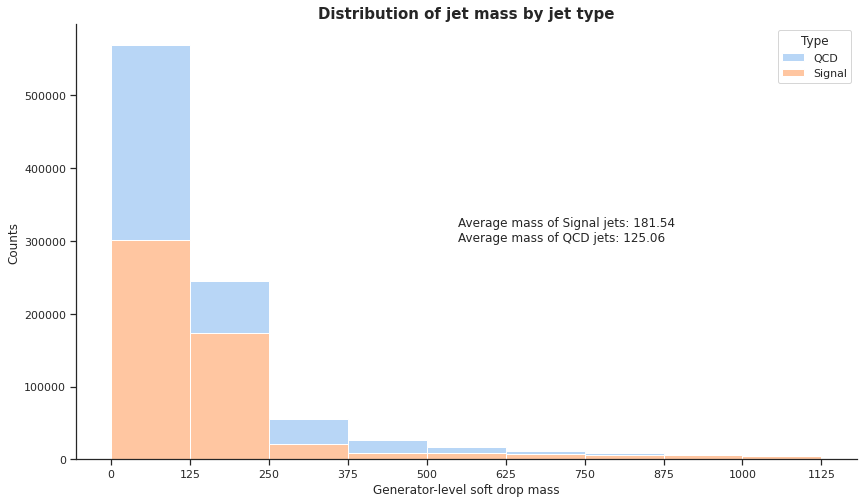

In [19]:
hist, summary = mass_distribution(df_qcd_and_signal)

display(summary)
print('\n')